## Predicting Heart Disease Through Classification with Health Indicators

Yiyao Ru, 
Liam Sissons,
Nizel Abalos,
Sebastian Yeo

## Introduction

   “Heart disease” refers to a varying number of heart related conditions that may include arrhythmias, heart attack, or even heart failure. There are several risk factors that may contribute to the development of heart disease including unhealthy lifestyle, genetics, smoking, and more. In particular, high blood pressure and high cholesterol are main factors that may contribute to the development of heart disease (About heart disease 2022).
   
  Using the “Heart Disease Data Set” from UCI’s Machine Learning Repository, this data analysis explores the relationship between heart disease and several variables including cholesterol, age, maximum heart rate and rest/exercise induced ST depression using a classification model. These variables were chosen based on exploration of their relationships with heart disease risk through visualizations. The variables that showed a trend in relation to heart disease risk were chosen. Cholesterol is a measurement of lipids in the blood, and age relates to years lived. Maximum heart rate looks at how high of a heart rate an individual can achieve, usually through exercise, and may indicate heart fitness. ST depression describes an abnormally low portion of the ST segment (area between QRS complex and T wave) on an electrocardiogram (ECG) reading (Rowden, 2022). ST depression may indicate several heart related health conditions. The specific data set from Cleveland was chosen due to the prevalence of heart disease related to lifestyle and health factors in the United States (U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? 2020). The dataset includes health related test results collected from about 300 patients in Cleveland and originates from the Cleveland Clinic Foundation. 
  
   A classification model will be created which will classify the chosen variables and be used to predict heart disease risk. The data analysis and classification should help to answer the question: To what extent can the risk level of heart disease (no risk, low risk, or high risk) be predicted using the collected Cleveland data on health variables including cholesterol, age, maximum heart rate, and ST depression induced by rest/exercise?



## Preliminary explanatory data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
processed_cleveland_hd <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
colnames(processed_cleveland_hd) <- c("age", "sex", "chestpain", "rest_bloodpressure", "chol", "fast_sugar", "restecg", "maxhr", "ex-anigna", "st_depression", "slope", "num_vessels", "thal", "num")
head(processed_cleveland_hd)

age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex-anigna,st_depression,slope,num_vessels,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [4]:
#Omit Categorical values : sex, cp, restecg, fbs, slope, exang, thal. K-nn classification does not work with categorical attributes.
hd_selected <- processed_cleveland_hd |>
    mutate(risk = ifelse(num==0,"No Risk", ifelse(num>=3, "High Risk", "Low Risk"))) |>
    select(age, rest_bloodpressure, chol, maxhr, st_depression, risk) |>
    mutate(risk = as_factor(risk))
head(hd_selected)

age,rest_bloodpressure,chol,maxhr,st_depression,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,No Risk
67,160,286,108,1.5,Low Risk
67,120,229,129,2.6,Low Risk
37,130,250,187,3.5,No Risk
41,130,204,172,1.4,No Risk
56,120,236,178,0.8,No Risk


In [5]:
#Splitting the data into a training and testing data set
set.seed(4321)

hd_split <- initial_split(hd_selected, prop = 0.75, strata = risk)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)

In [6]:
hd_predictors_train <- hd_train |>
    select(age, rest_bloodpressure, chol, maxhr, st_depression,risk) |>
    group_by(risk) |>
    summarize(across(age:st_depression, mean))|>
    arrange(risk)

hd_observations <- hd_train |>
    group_by(risk) |>
    summarise(count = n())

hd <- merge(hd_predictors_train, hd_observations, on = "risk")

distinct(hd)

risk,age,rest_bloodpressure,chol,maxhr,st_depression,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
High Risk,58.11111,133.5833,255.8889,135.1111,1.8694444,36
Low Risk,56.72059,134.8382,252.7206,141.8088,1.3102941,68
No Risk,52.16260,129.0732,243.0976,158.8455,0.6130081,123


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



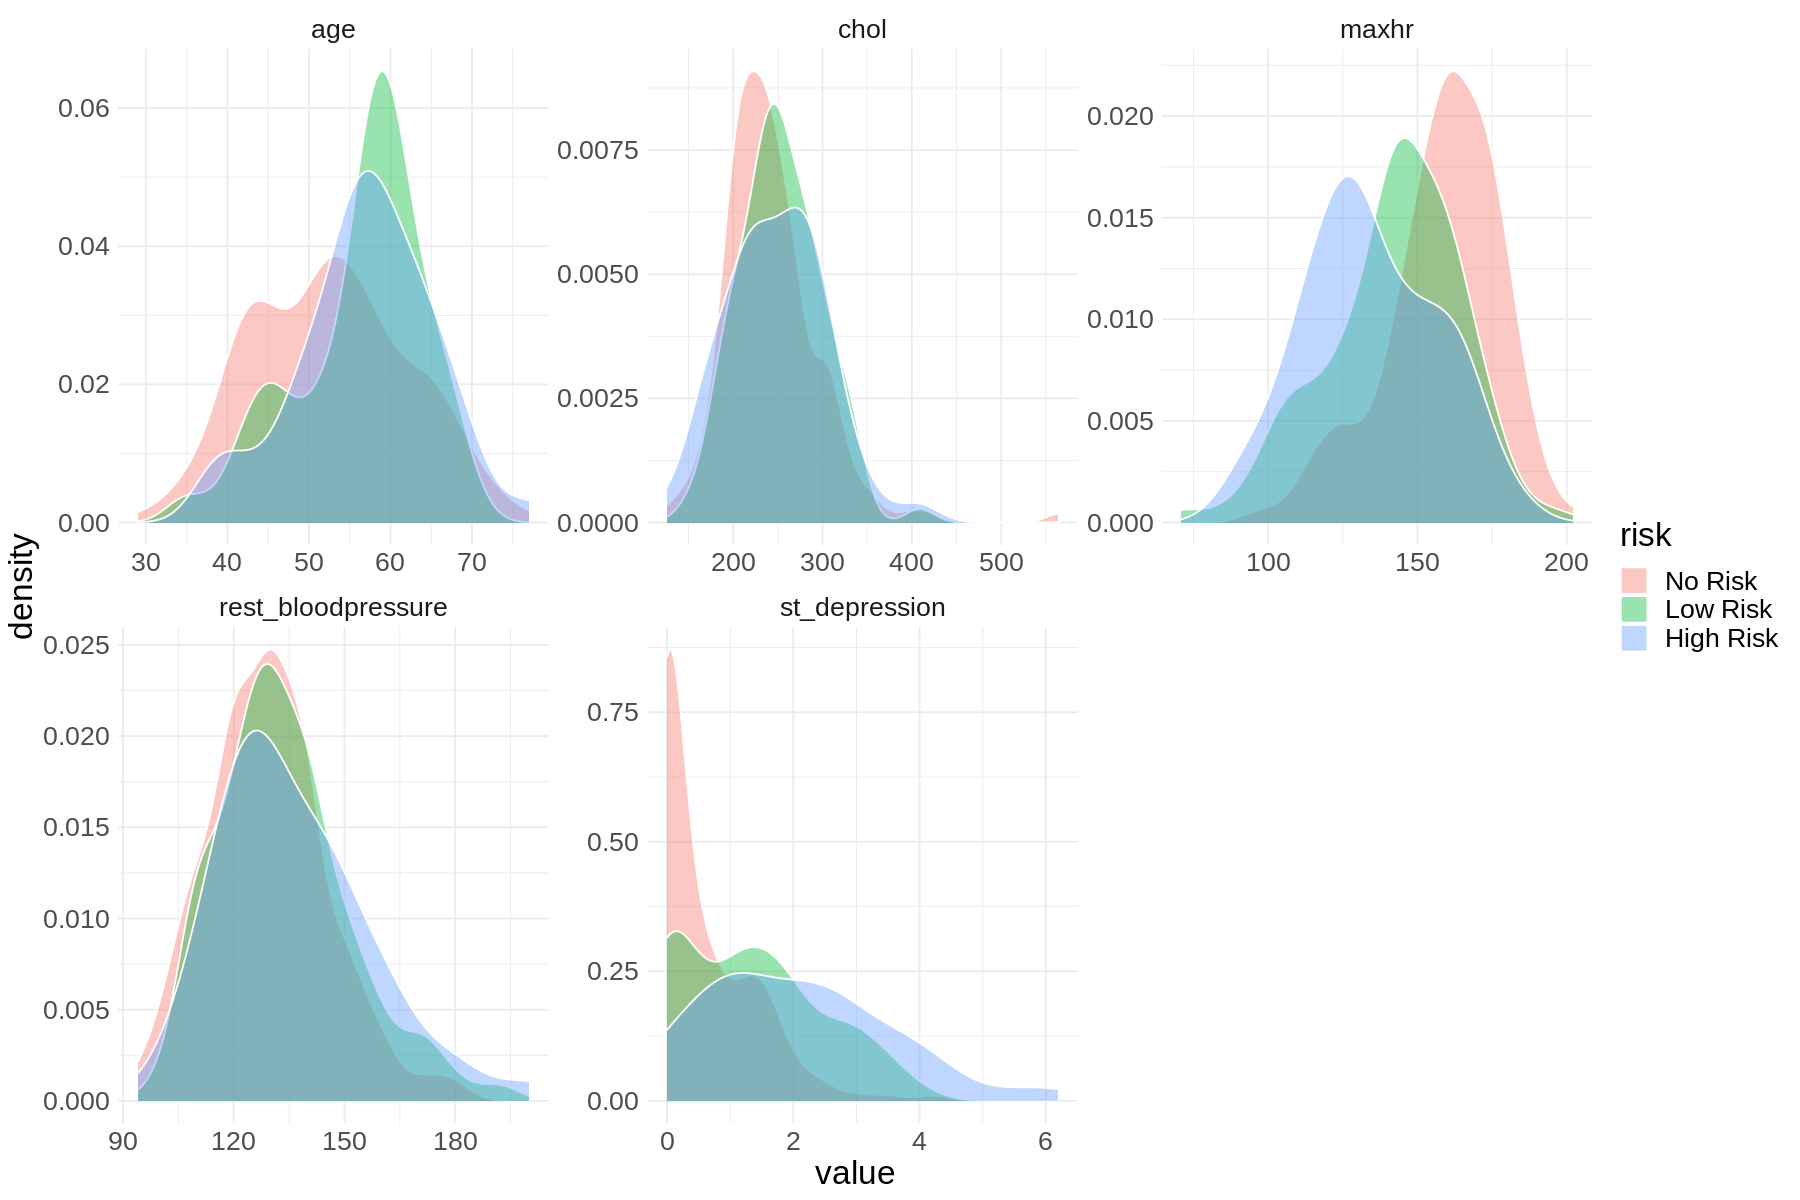

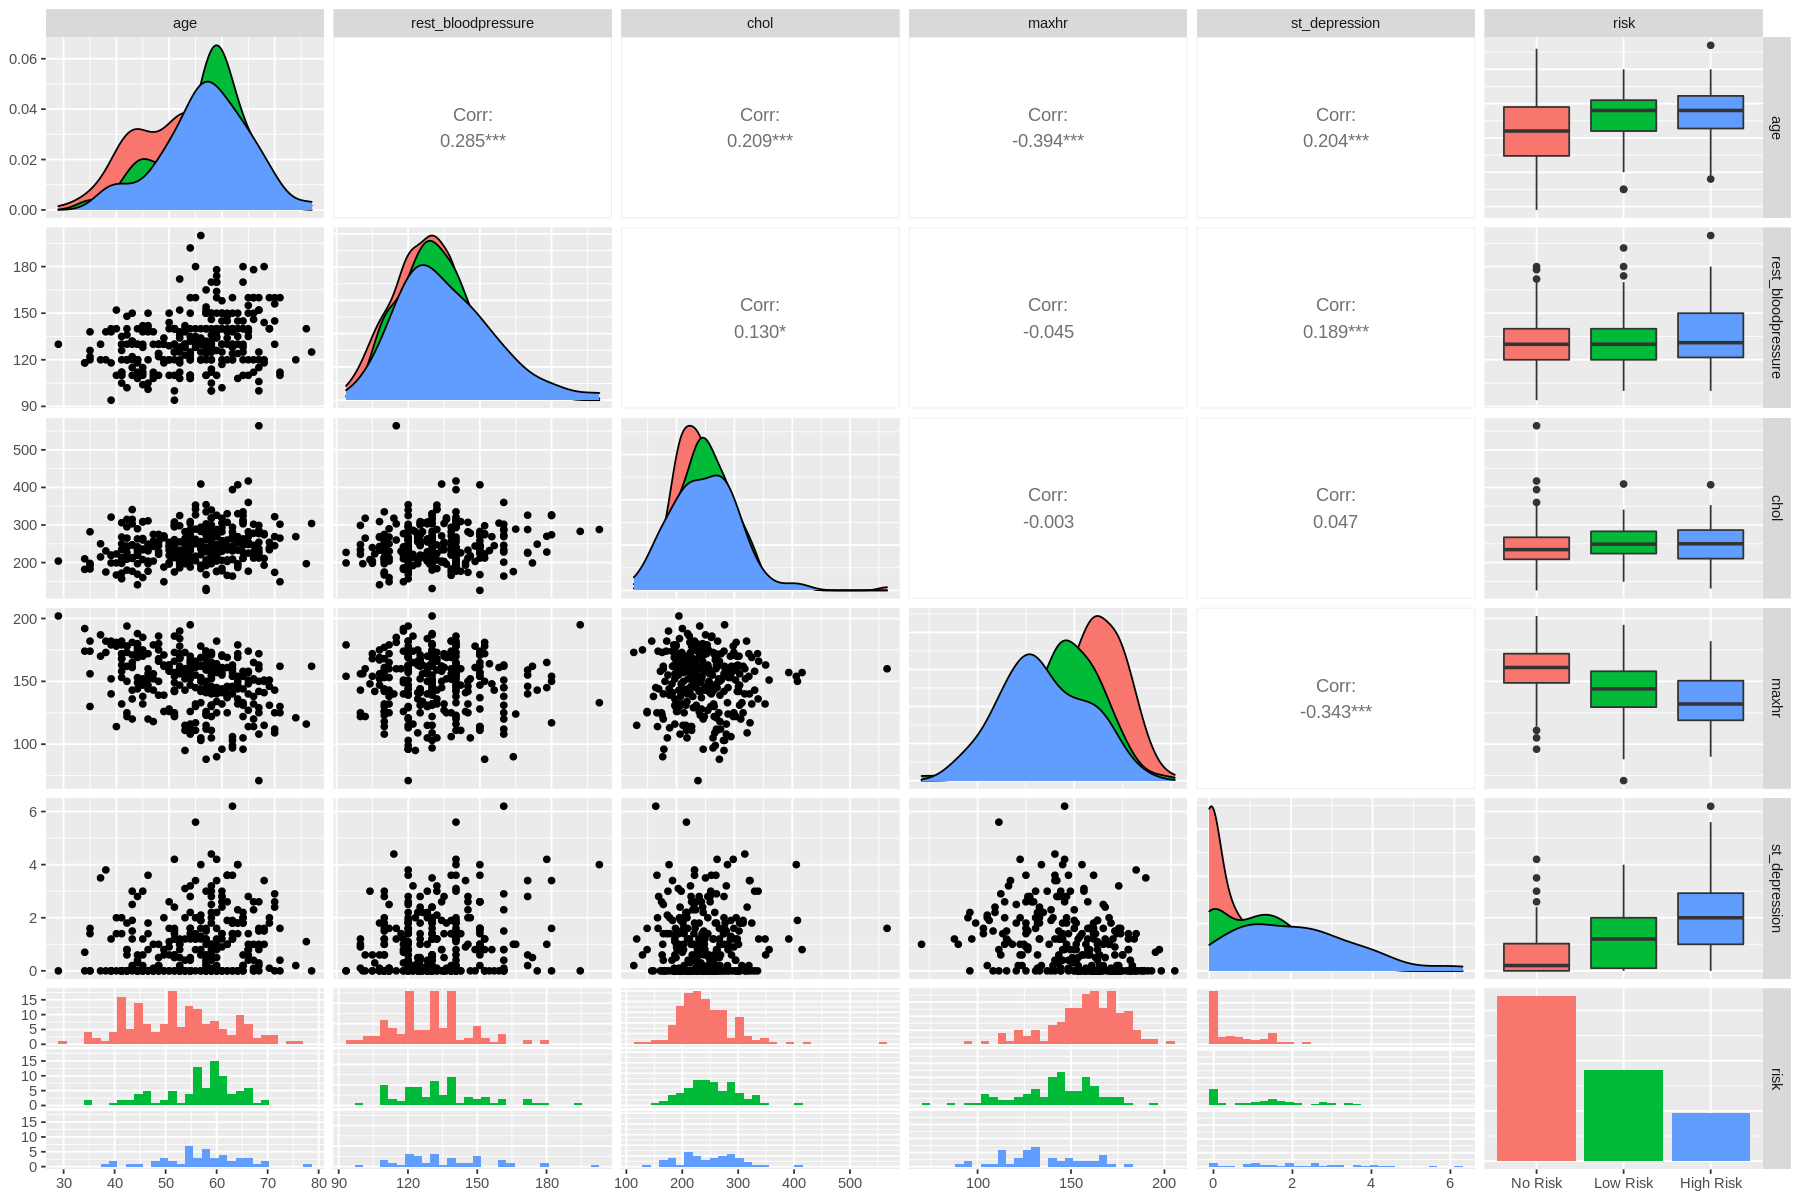

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10)
hd_plot <- hd_selected |>
    pivot_longer(cols = -risk, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = risk)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))
hd_plot
hd_pairs <- hd_selected |>
    ggpairs(aes(fill=risk))
hd_pairs

In [14]:
set.seed(2022)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
hd_recipe <- recipe(risk ~ age + st_depression + maxhr + chol, data = hd_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
hd_vfold <- vfold_cv(hd_train, v = 10, strata = risk)
hd_tune <- workflow() |>
                  add_recipe(hd_recipe) |>
                  add_model(knn_tune) |>
                  tune_grid(resamples = hd_vfold, grid=k_vals) |>
                  collect_metrics()
hd_accuracies <- hd_tune |>
    filter(.metric == "accuracy")

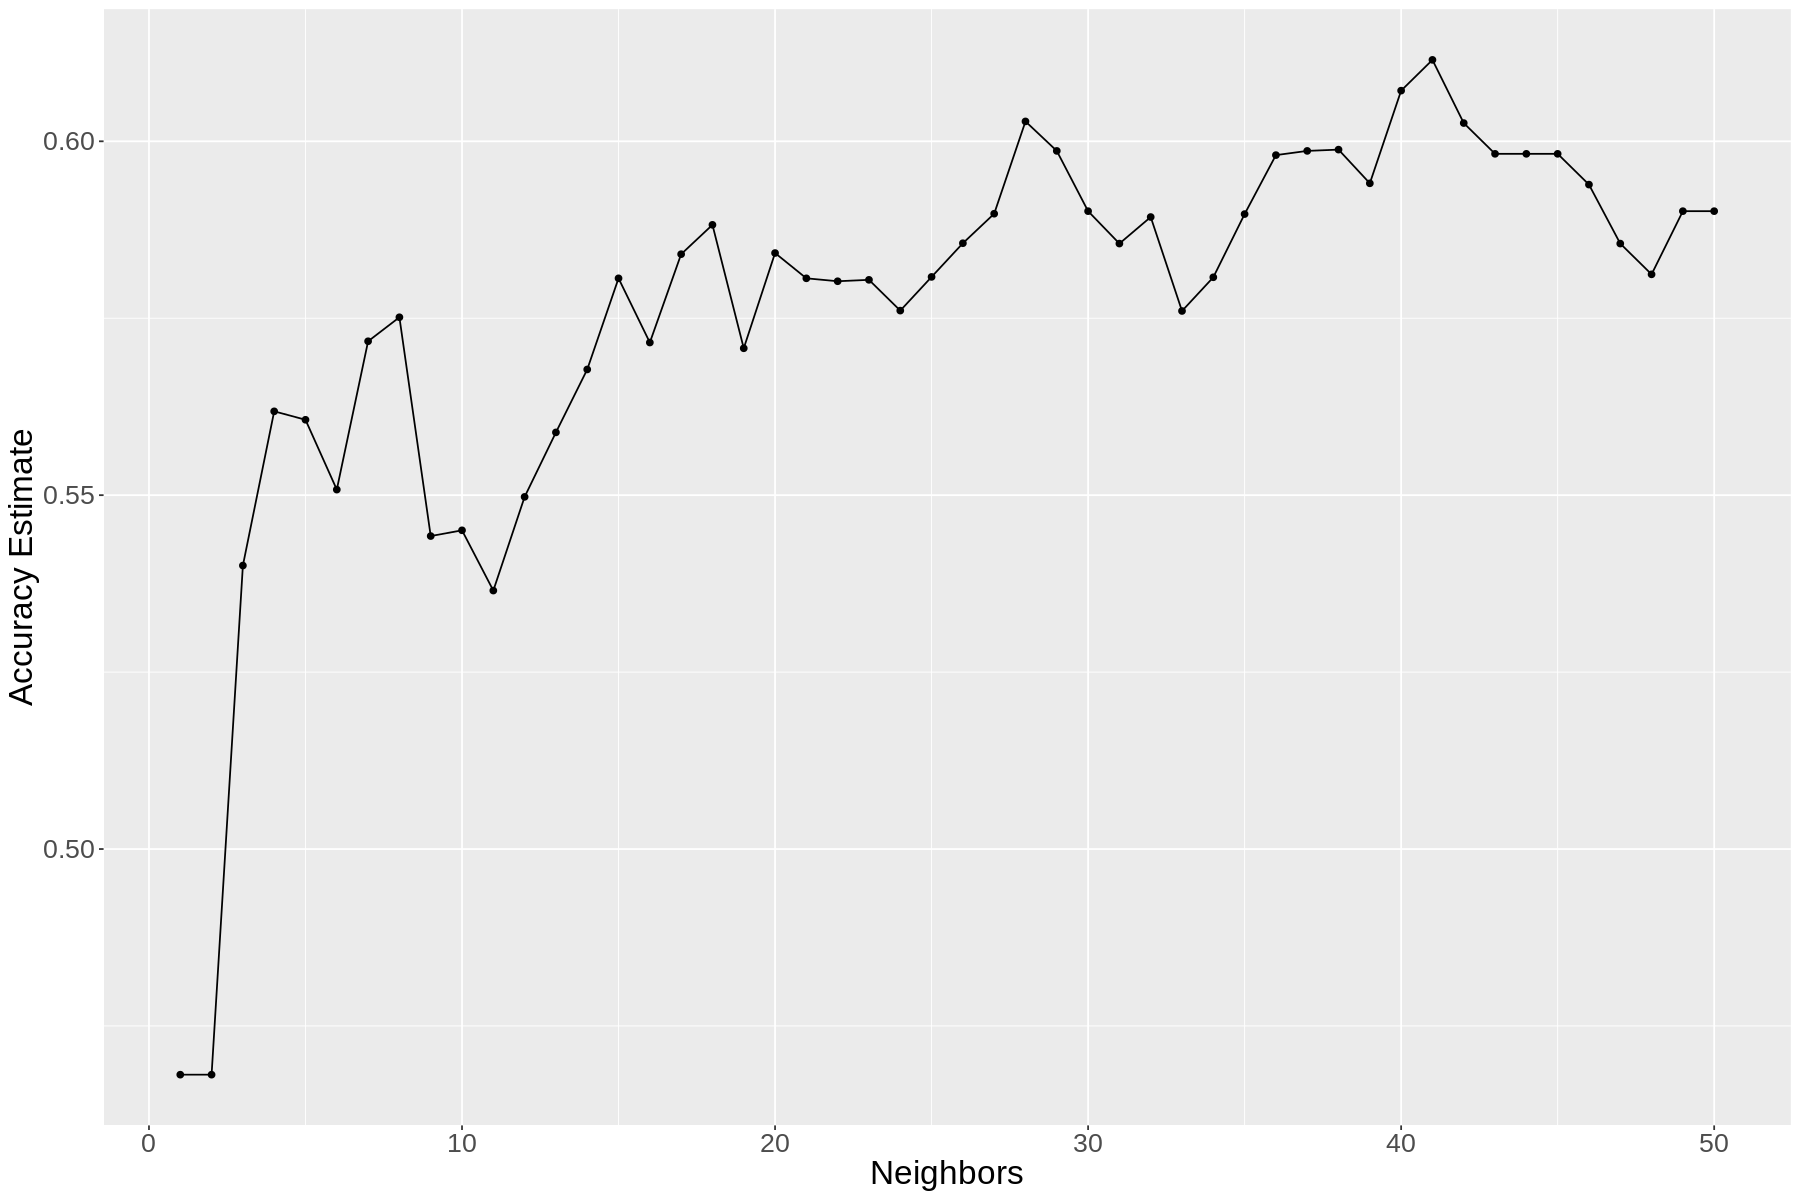

In [15]:
knn_plot <- ggplot(hd_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 20))
knn_plot

In [16]:
k_selected <- hd_accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    select(neighbors) |>
    pull()
k_selected
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = k_selected) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_fit <- workflow() |>
    add_recipe(hd_recipe) |>
    add_model(knn_spec) |>
    fit(data = hd_train)
hd_predictions <- predict(knn_fit, hd_test) |>
  bind_cols(hd_test)
hd_predictions |>
  metrics(truth = risk, estimate = .pred_class) |>
  filter(.metric == "accuracy")

[1] 41

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6052632


## Methods

 The variables that will be examined are cholesterol (chol), age (age), fasting blood sugar (fbs) and resting blood pressure (trestbps). That being said, other unneeded columns will be filtered out. The required libraries to be loaded include tidyverse, repr, tidymodels and RColorBrewer. The selected variables will be used to create a knn classification model to predict heart disease risk. When building the model, the data will be split into two groups: training and testing. The training data will be used to train the model, and then be tested with the testing data. Since the value of k in the model might influence the accuracy of the model, various values of k will be tested to determine the k with the highest accuracy. The results will be visualized as a line graph with the accuracies of the models and the values of k, as that will help answer the question.

## Expected Outcomes and Questions

 The expected outcome of this data analysis is to determine the risk level for heart disease (ranging from 0-4, 0 indicating no presence, to 4 being very risky) based on the chosen variables  (cholesterol level, age, fasting blood sugar and resting blood pressure). Based on previous knowledge, high cholesterol, blood sugar and blood pressure will likely be associated with higher prevalence of heart disease. By identifying how these variables influence risk of heart disease for a certain age group, medical professionals could identify patients with high risk earlier and provide appropriate care and prevention. 
 This data analysis could lead to future questions regarding other potential risk factors and how much they influence the likelihood of developing heart disease. Another question that this data set does not address is whether or not certain variables are influenced by genetic factors or lifestyle and how this difference could change the way they are addressed by medical professionals.


## Work Cited

About heart disease. Centers for Disease Control and Prevention. (2022, July 12). Retrieved …March 2, 2023, from https://www.cdc.gov/heartdisease/about.htm 

Robert, D. Heart Disease Data Set. UCI Machine Learning Repository. Retrieved March 2, …2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Rowden, A. (July, 2022). St depression on ECG: What it means and causes. Medical News …Today. from https://www.medicalnewstoday.com/articles/st-depression-on-ecg 

U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? U.S. Health …Care from a Global Perspective, 2019 | Commonwealth Fund. (2020, January 30). Retrieved …March 2, 2023, from …https://www.commonwealthfund.org/publications/issue-briefs/2020/jan/us-health-care-global-p…erspective-2019#:~:text=More%20than%20one%2Dquarter%20of,less%20in%20all%20other…%20countries 
